In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

In [2]:
spark = SparkSession.builder \
    .appName("empdata") \
    .master("local[*]")\
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/07 14:25:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
employment_df = spark.read.csv("../flight_data/empData_Monthly.txt", header=True, sep="\t", inferSchema=True)
cleaned_columns = [col.strip() for col in employment_df.columns]
employment_df = employment_df.toDF(*cleaned_columns)

In [4]:
employment_df.show()

24/12/07 12:47:28 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+-----+------+------+------+-------+------+------+-----+-----+------+------+-----+------+-----+------+------+------+------+------+------+------+-----+------+------+------+------+-----+------+-----+-----+------+-----+------+------+------+------+------+------+-----+------+-----+------+------+------+------+-----+------+------+-----+-----+
|      DATE|AKNAN| ALNAN| ARNAN| AZNAN|  CANAN| CONAN| CTNAN|DCNAN|DENAN| FLNAN| GANAN|HINAN| IANAN|IDNAN| ILNAN| INNAN| KSNAN| KYNAN| LANAN| MANAN| MDNAN|MENAN| MINAN| MNNAN| MONAN| MSNAN|MTNAN| NCNAN|NDNAN|NHNAN| NJNAN|NMNAN| NVNAN| NYNAN| OHNAN| OKNAN| ORNAN| PANAN|RINAN| SCNAN|SDNAN| TNNAN| TXNAN| UTNAN| VANAN|VTNAN| WANAN| WINAN|WVNAN|WYNAN|
+----------+-----+------+------+------+-------+------+------+-----+-----+------+------+-----+------+-----+------+------+------+------+------+------+------+-----+------+------+------+------+-----+------+-----+-----+------+-----+------+------+------+------+------+------+-----+------+-----+------+------+

In [5]:
passenger_df = spark.read.csv("../flight_data/footfall/data_*.csv", header=True, inferSchema=True)

In [6]:
passenger_df.show()

+--------------------+--------------------+-------+-----+----------+-------+----+--------+------------+--------+--------------+----------+--------------------+---------------------+------+-------+--------------------+-------------+-----------------+-----------------+---------------------+---------------------+------+----------------+----------------+-----------------+---------------+----------+---------------+-------------------+-------------------+----+----------------+--------------+---------------+-------------+--------+--------------+-------------+---------------+----+-------+-----+--------------+-----+
|DEPARTURES_SCHEDULED|DEPARTURES_PERFORMED|PAYLOAD|SEATS|PASSENGERS|FREIGHT|MAIL|DISTANCE|RAMP_TO_RAMP|AIR_TIME|UNIQUE_CARRIER|AIRLINE_ID| UNIQUE_CARRIER_NAME|UNIQUE_CARRIER_ENTITY|REGION|CARRIER|        CARRIER_NAME|CARRIER_GROUP|CARRIER_GROUP_NEW|ORIGIN_AIRPORT_ID|ORIGIN_AIRPORT_SEQ_ID|ORIGIN_CITY_MARKET_ID|ORIGIN|ORIGIN_CITY_NAME|ORIGIN_STATE_ABR|ORIGIN_STATE_FIPS|ORIGIN_STATE_NM

In [46]:
passenger_df.describe()


ConnectionRefusedError: [Errno 61] Connection refused

In [45]:
passenger_df.toPandas().to_csv('../flight_data/passengers.csv')


ConnectionRefusedError: [Errno 61] Connection refused

In [8]:
employment_df = employment_df.withColumn("YEAR", F.year("DATE")).withColumn("MONTH", F.month("DATE"))

In [11]:
state_abbrs = {k.replace("NAN", ""):k for k in employment_df.columns if "NAN" in k }
state_abbrs

{'AK': 'AKNAN',
 'AL': 'ALNAN',
 'AR': 'ARNAN',
 'AZ': 'AZNAN',
 'CA': 'CANAN',
 'CO': 'CONAN',
 'CT': 'CTNAN',
 'DC': 'DCNAN',
 'DE': 'DENAN',
 'FL': 'FLNAN',
 'GA': 'GANAN',
 'HI': 'HINAN',
 'IA': 'IANAN',
 'ID': 'IDNAN',
 'IL': 'ILNAN',
 'IN': 'INNAN',
 'KS': 'KSNAN',
 'KY': 'KYNAN',
 'LA': 'LANAN',
 'MA': 'MANAN',
 'MD': 'MDNAN',
 'ME': 'MENAN',
 'MI': 'MINAN',
 'MN': 'MNNAN',
 'MO': 'MONAN',
 'MS': 'MSNAN',
 'MT': 'MTNAN',
 'NC': 'NCNAN',
 'ND': 'NDNAN',
 'NH': 'NHNAN',
 'NJ': 'NJNAN',
 'NM': 'NMNAN',
 'NV': 'NVNAN',
 'NY': 'NYNAN',
 'OH': 'OHNAN',
 'OK': 'OKNAN',
 'OR': 'ORNAN',
 'PA': 'PANAN',
 'RI': 'RINAN',
 'SC': 'SCNAN',
 'SD': 'SDNAN',
 'TN': 'TNNAN',
 'TX': 'TXNAN',
 'UT': 'UTNAN',
 'VA': 'VANAN',
 'VT': 'VTNAN',
 'WA': 'WANAN',
 'WI': 'WINAN',
 'WV': 'WVNAN',
 'WY': 'WYNAN'}

In [12]:
emp_unpivot_df = employment_df.select(
    "DATE", "YEAR", "MONTH",
    *[F.col(col).alias(f"{col}") for col in state_abbrs.values()]
).selectExpr(
    "DATE", "YEAR", "MONTH",
    "stack(" + str(len(state_abbrs)) + ", " + 
    ", ".join([f"'{state}', {col}" for state, col in state_abbrs.items()]) +
    ") as (state, employment_stat)"
)

In [42]:
def plot_state_data(state, col, ppd):
    state_df = ppd[ppd[col] == state]
    plt.figure(figsize=(10, 6))
    plt.plot(state_df["datetime"], state_df["normalized_passengers"], label=col, marker="o")
    plt.plot(state_df["datetime"], state_df["normalized_employment"], label="Employment Stat", marker="s")
    plt.xlabel("Date")
    plt.ylabel("Normalized Values")
    plt.title(f"Normalized Trends of Passengers and Employment for {state}")
    plt.axvline(pd.Timestamp("2007-12-01"), color="red", linestyle="--", label="Dec 2007 (Global Economic Crisis)")
    plt.axvline(pd.Timestamp("2020-03-01"), color="red", linestyle="--", label="Mar 2020 (COVID)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualization 

# inbound travel stats

In [9]:
passenger_agg_df = passenger_df.groupBy("YEAR", "MONTH", "DEST_STATE_ABR").agg(
    F.sum("PASSENGERS").alias("total_inbound_passengers")
)

In [10]:
passenger_agg_df.show()

+----+-----+--------------+------------------------+
|YEAR|MONTH|DEST_STATE_ABR|total_inbound_passengers|
+----+-----+--------------+------------------------+
|2023|   10|            AR|                202083.0|
|2023|    3|            NJ|               1631505.0|
|2023|    2|            MO|                875586.0|
|2023|    7|            NY|               3295164.0|
|2023|    2|            UT|                957632.0|
|2023|    4|            WI|                419851.0|
|2023|    7|            FL|               7408832.0|
|2023|    1|            WA|               1667796.0|
|2023|   11|            MT|                183921.0|
|2023|   10|            HI|               1341320.0|
|2023|    2|            NC|               2244632.0|
|2023|    7|            MA|               1526204.0|
|2023|   12|            NC|               2834517.0|
|2023|    9|            UT|               1050263.0|
|2023|    5|            MS|                100325.0|
|2023|    1|            TN|               1035

In [20]:
emp_unpivot_df.show()

+----------+----+-----+-----+---------------+
|      DATE|YEAR|MONTH|state|employment_stat|
+----------+----+-----+-----+---------------+
|2000-01-01|2000|    1|   AK|          262.1|
|2000-01-01|2000|    1|   AL|         1918.2|
|2000-01-01|2000|    1|   AR|         1136.5|
|2000-01-01|2000|    1|   AZ|         2183.9|
|2000-01-01|2000|    1|   CA|        14133.1|
|2000-01-01|2000|    1|   CO|         2133.8|
|2000-01-01|2000|    1|   CT|         1665.3|
|2000-01-01|2000|    1|   DC|          628.9|
|2000-01-01|2000|    1|   DE|          407.1|
|2000-01-01|2000|    1|   FL|         6904.2|
|2000-01-01|2000|    1|   GA|         3882.1|
|2000-01-01|2000|    1|   HI|          535.5|
|2000-01-01|2000|    1|   IA|         1446.1|
|2000-01-01|2000|    1|   ID|          533.4|
|2000-01-01|2000|    1|   IL|         5872.2|
|2000-01-01|2000|    1|   IN|         2951.3|
|2000-01-01|2000|    1|   KS|         1317.8|
|2000-01-01|2000|    1|   KY|         1770.9|
|2000-01-01|2000|    1|   LA|     

In [22]:
# Join passenger stats with employment stats
combined_df = passenger_agg_df.join(
    emp_unpivot_df,
    (passenger_agg_df["YEAR"] == emp_unpivot_df["YEAR"]) &
    (passenger_agg_df["MONTH"] == emp_unpivot_df["MONTH"]) &
    (passenger_agg_df["DEST_STATE_ABR"] == emp_unpivot_df["state"]),
    how="inner"
).select(
    passenger_agg_df["YEAR"],
    passenger_agg_df["MONTH"],
    passenger_agg_df["DEST_STATE_ABR"],
    "total_inbound_passengers",
    "employment_stat"
)

In [23]:
combined_df.show()

+----+-----+--------------+------------------------+---------------+
|YEAR|MONTH|DEST_STATE_ABR|total_inbound_passengers|employment_stat|
+----+-----+--------------+------------------------+---------------+
|2023|   10|            AR|                202083.0|         1363.8|
|2023|    3|            NJ|               1631505.0|         4257.1|
|2023|    2|            MO|                875586.0|         2933.8|
|2023|    7|            NY|               3295164.0|         9768.3|
|2023|    2|            UT|                957632.0|         1702.7|
|2023|    4|            WI|                419851.0|         2999.2|
|2023|    7|            FL|               7408832.0|         9635.5|
|2023|    1|            WA|               1667796.0|         3527.9|
|2023|   11|            MT|                183921.0|          521.1|
|2023|   10|            HI|               1341320.0|          629.9|
|2023|    2|            NC|               2244632.0|         4886.1|
|2023|    7|            MA|       

In [24]:
combined_df = combined_df.withColumn("datetime", F.to_date(F.concat(F.col("YEAR"), F.lit("-"), F.col("MONTH"), F.lit("-01"))))


In [58]:
scaler_passengers = MinMaxScaler()
scaler_employment = MinMaxScaler()

In [51]:
combined_pd = combined_df.select("datetime", "DEST_STATE_ABR", "total_inbound_passengers", "employment_stat").toPandas()


In [59]:
combined_pd["normalized_passengers"] = scaler_passengers.fit_transform(combined_pd[["total_inbound_passengers"]])
combined_pd["normalized_employment"] = scaler_employment.fit_transform(combined_pd[["employment_stat"]])

In [60]:
combined_pd = combined_pd.sort_values(by=["DEST_STATE_ABR", "datetime"])

In [61]:
combined_pd

,datetime,DEST_STATE_ABR,total_inbound_passengers,employment_stat,normalized_passengers,normalized_employment
12838,2000-01-01,AK,207050.0,262.1,0.022075,0.001909
13194,2000-02-01,AK,184877.0,269.6,0.019711,0.002329
12578,2000-03-01,AK,230664.0,273.0,0.024593,0.002519
13362,2000-04-01,AK,216452.0,276.0,0.023077,0.002687
13265,2000-05-01,AK,284511.0,288.4,0.030334,0.003381
...,...,...,...,...,...,...
238,2023-08-01,WY,82742.0,297.8,0.008822,0.003908
518,2023-09-01,WY,69425.0,297.9,0.007402,0.003913
355,2023-10-01,WY,47111.0,295.1,0.005023,0.003756
297,2023-11-01,WY,39765.0,291.4,0.004240,0.003549


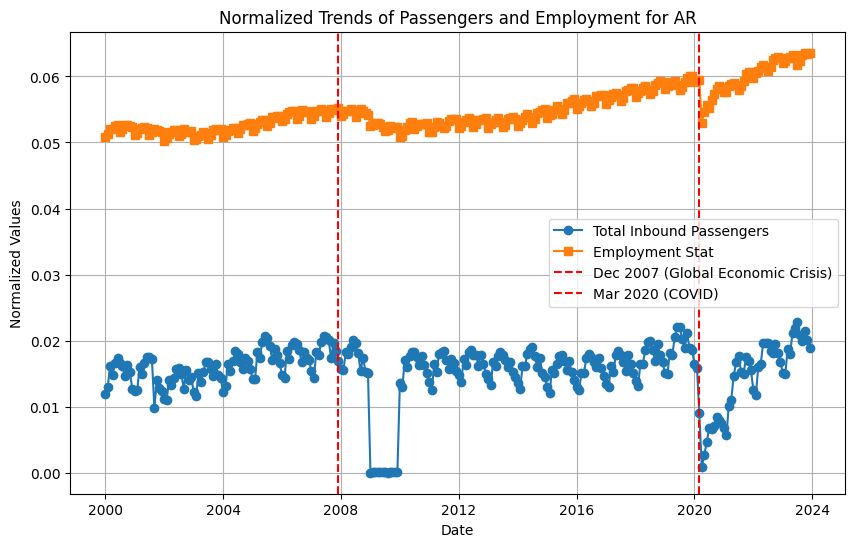

In [ ]:
plot_state_data("AR","DEST_STATE_ABBR", combined_pd)

# outbound travel stats 

In [27]:
inbound_df = passenger_df.groupBy("YEAR", "MONTH", "ORIGIN_STATE_ABR").agg(
    F.sum("PASSENGERS").alias("total_outbound_passengers")
)

In [28]:
combined_df = inbound_df.join(
    emp_unpivot_df,
    (inbound_df["YEAR"] == emp_unpivot_df["YEAR"]) &
    (inbound_df["MONTH"] == emp_unpivot_df["MONTH"]) &
    (inbound_df["ORIGIN_STATE_ABR"] == emp_unpivot_df["state"]),
    how="inner"
).select(
    inbound_df["YEAR"],
    inbound_df["MONTH"],
    inbound_df["ORIGIN_STATE_ABR"],
    "total_outbound_passengers",
    "employment_stat"
)

In [29]:
combined_df = combined_df.withColumn("datetime", F.to_date(F.concat(F.col("YEAR"), F.lit("-"), F.col("MONTH"), F.lit("-01"))))

In [30]:
scaler_passengers = MinMaxScaler()
scaler_employment = MinMaxScaler()


In [31]:
combined_pd = combined_df.select("datetime", "ORIGIN_STATE_ABR", "total_outbound_passengers", "employment_stat").toPandas()

In [32]:
combined_pd["normalized_passengers"] = scaler_passengers.fit_transform(combined_pd[["total_outbound_passengers"]])
combined_pd["normalized_employment"] = scaler_employment.fit_transform(combined_pd[["employment_stat"]])

In [33]:
combined_pd = combined_pd.sort_values(by=["ORIGIN_STATE_ABR", "datetime"])
combined_pd

,datetime,ORIGIN_STATE_ABR,total_outbound_passengers,employment_stat,normalized_passengers,normalized_employment
12823,2000-01-01,AK,179147.0,262.1,0.019233,0.001909
13179,2000-02-01,AK,169732.0,269.6,0.018222,0.002329
12563,2000-03-01,AK,230132.0,273.0,0.024707,0.002519
13347,2000-04-01,AK,200699.0,276.0,0.021547,0.002687
13248,2000-05-01,AK,255307.0,288.4,0.027409,0.003381
...,...,...,...,...,...,...
237,2023-08-01,WY,84216.0,297.8,0.009041,0.003908
518,2023-09-01,WY,73766.0,297.9,0.007919,0.003913
353,2023-10-01,WY,53328.0,295.1,0.005725,0.003756
297,2023-11-01,WY,40536.0,291.4,0.004352,0.003549


AttributeError: 'DataFrame' object has no attribute 'Timestamp'

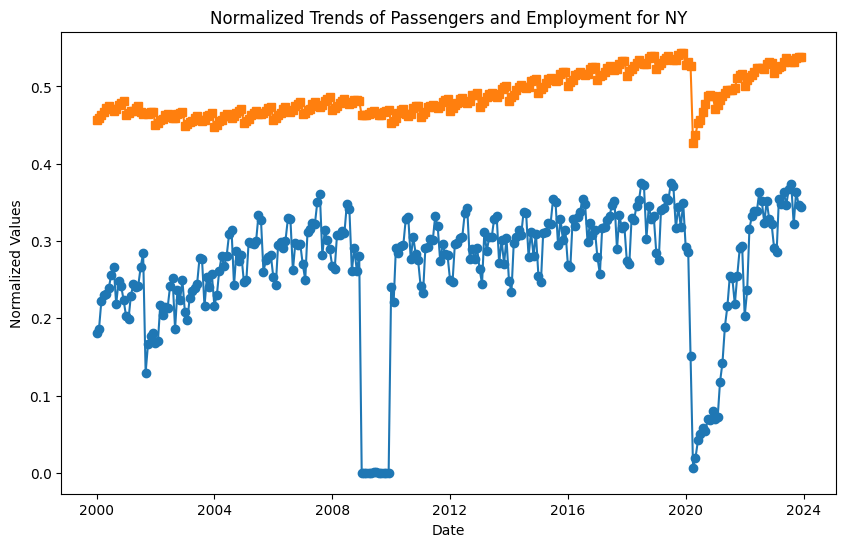

In [41]:
plot_state_data("NY", "ORIGIN_STATE_ABR", combined_pd)

# more ideas here

In [38]:
passenger_df

DataFrame[DEPARTURES_SCHEDULED: double, DEPARTURES_PERFORMED: double, PAYLOAD: double, SEATS: double, PASSENGERS: double, FREIGHT: double, MAIL: double, DISTANCE: double, RAMP_TO_RAMP: double, AIR_TIME: double, UNIQUE_CARRIER: string, AIRLINE_ID: int, UNIQUE_CARRIER_NAME: string, UNIQUE_CARRIER_ENTITY: string, REGION: string, CARRIER: string, CARRIER_NAME: string, CARRIER_GROUP: int, CARRIER_GROUP_NEW: int, ORIGIN_AIRPORT_ID: int, ORIGIN_AIRPORT_SEQ_ID: int, ORIGIN_CITY_MARKET_ID: int, ORIGIN: string, ORIGIN_CITY_NAME: string, ORIGIN_STATE_ABR: string, ORIGIN_STATE_FIPS: int, ORIGIN_STATE_NM: string, ORIGIN_WAC: int, DEST_AIRPORT_ID: int, DEST_AIRPORT_SEQ_ID: int, DEST_CITY_MARKET_ID: int, DEST: string, DEST_CITY_NAME: string, DEST_STATE_ABR: string, DEST_STATE_FIPS: int, DEST_STATE_NM: string, DEST_WAC: int, AIRCRAFT_GROUP: int, AIRCRAFT_TYPE: int, AIRCRAFT_CONFIG: int, YEAR: int, QUARTER: int, MONTH: int, DISTANCE_GROUP: int, CLASS: string]